# Knowledge graph using `semantikon`

## Background

If you are somewhat familiar with ontology, you must have encountered the problem: There is an ontology for your field available, along with some simulation tools. You would like to combine them to give ontological information to your data, but it is just too much of an effort to understand the structure of the ontology and integrate it into your workflow. `semantikon` gives you a simple tool to easily annotate your workflow nodes with ontological information.

## Data aquisition

The following example shows a simple workflow containing two steps: 1. calculate speed from distance and time; 2. calculate corresponding kinetic energy. For this and following examples we use a mock up ontology `EX`, which should be replaced by the ontology of your choice.

In [1]:
from rdflib import Namespace

In [2]:
EX = Namespace("http://www.example.org/")

In [3]:
from semantikon.metadata import u
from semantikon.ontology import get_knowledge_graph
from semantikon.workflow import get_workflow_dict


def get_speed(
    distance: u(float, uri=EX.distance, units="meter"),
    time: u(float, uri=EX.time, units="second")
) -> u(float, uri=EX.velocity, units="meter/second"):
    speed = distance / time
    return speed


def get_kinetic_energy(
    mass: u(float, uri=EX.mass, units="kilogram"),
    velocity: u(float, uri=EX.velocity, units="meter/second")
) -> u(float, uri=EX.kineticEnergy, units="joule"):
    return 0.5 * mass * velocity**2

Based on the two functions/nodes `get_speed` and `get_kinetic_energy`, we create the following workflow

In [4]:
def my_workflow(distance, time, mass):
    speed = get_speed(distance, time)
    kinetic_energy = get_kinetic_energy(mass, speed)
    return kinetic_energy

Note: `semantikon` also offers some basic workflow managing tools, but ideally you should use the workflow manager of your choice, such as `pyiron_workflow`. There is an ongoing development to represent workflows in a unified format, which would allow `semantikon` to directly obtain ontological information from the workflow manager.

In [5]:
# Extract knowledge graph
graph = get_knowledge_graph(get_workflow_dict(my_workflow))

Now you can visualize the knowledge graph with the tool of your choice. You can also use the one from `semantikon`

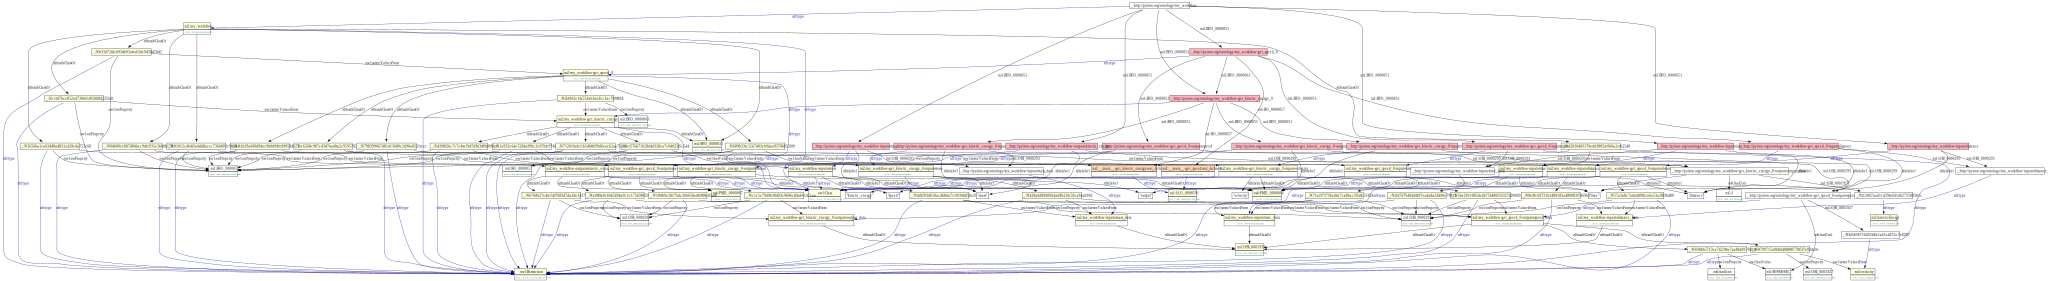

In [6]:
from semantikon.visualize import visualize

visualize(graph)

## Validate connections

One of the reasons to semantically describe workflows is to validate input and output connections. `semantikon` offers the following validation schemes:

- Type checking
- OWL restrictions
- SHACL constraints

We show the examples below how these checks can be performed.

Note: `semantikon` currently does not support python type checking. This is because it fully focuses on the semantic types defined in the knowledge graph. This might be included at some point in the future though.

### Type checking

In this example, the node `eat` accepts anything that's meal, so we prepare pizza, which is a subclass of meal and insert it into `eat`.

In [7]:
from semantikon.ontology import validate_values


In [8]:
class Meal:
    pass


def prepare_pizza() -> u(Meal, uri=EX.Pizza):
    return Meal()


def eat(meal: u(Meal, uri=EX.Meal)) -> str:
    return "I am full after eating "


def eat_pizza():
    pizza = prepare_pizza()
    comment = eat(pizza)
    return comment


wf_dict = get_workflow_dict(eat_pizza)
graph = get_knowledge_graph(wf_dict)
verdict, _, report = validate_values(graph, run_reasoner=False)
assert not verdict

At this point, since the ontology is not defined, `validate_values` thinks `EX.Pizza` is not compatible with `EX.Meal`, so we extend the ontology to indicate that pizza is also a meal:

In [9]:
from rdflib import RDFS

In [10]:
graph.add((EX.Pizza, RDFS.subClassOf, EX.Meal))
verdict, _, report = validate_values(graph)
assert verdict
print(report)

Validation Report
Conforms: True



### Define restrictions

Let's take the following example: You would like to represent the supply chain of clothes. Before they are sold, they have to be dyed and washed. Typically, these nodes (`wash` and `dye`) are performed by different players, so that their processes do not require the clothes to have gone through certain processes beforehand. In other words, you can dye clothes whether they have been washed before or not, which also applies to washing. However, you would like to apply the restriction on the input clothes of `sell` to have gone through `wash` and `dye` beforehand. That's a very difficult condition to represent using conventional python classes, but `semantikon` can handle it.

Here's what's expected in short (it does not render nicely on GitHub -> load it in your jupyter environment):

`def dye`:
```mermaid
flowchart LR
clothes(clothes) --> dye[[dye]] --> dyed(clothes + dyed)
```

`def wash`:
```mermaid
flowchart LR
clothes(clothes) --> wash[[wash]] --> washed(clothes + washed)
```

`def sell`:
```mermaid
flowchart LR
clothes(clothes + dyed + washed) --> sell[[sell]]
```

In [11]:
from rdflib import OWL, Namespace

from semantikon.metadata import u, SemantikonURI

EX = Namespace("http://www.example.org/")

uri_color = SemantikonURI(EX.Color)
uri_cleaned = SemantikonURI(EX.Cleaned)

class Clothes:
    pass

def wash(clothes: Clothes) -> u(
    Clothes,
    triples=(EX.hasProperty, uri_cleaned),
    derived_from="inputs.clothes"
):
    ...
    return clothes

def dye(clothes: Clothes, color="blue") -> u(
    Clothes,
    triples=(EX.hasProperty, uri_color),
    derived_from="inputs.clothes",
):
    ...
    return clothes

def sell(
    clothes: u(
        Clothes, restrictions=(
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.Cleaned)),
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.Color))
        )
    )
) -> int:
    ...
    return 10

`derived_from` is a `semantikon` argument based on `prov:wasDerivedFrom` or `bfo:derives_from` to indicate that the output inherits properties (not ontological properties) from the inputs. If this predicate is not applied, `semantikon` does not create a direct connection between the input and the output.

The notation `triples=(EX.hasProperty, EX.cleaned))` is the short form for `triples=("outputs.clothes", EX.hasProperty, EX.cleaned)`. In this case `outputs.clothes` is automatically replaced by the ontological node that is created for the output. The following notations are equivalent:

- `triples=(EX.hasProperty, EX.cleaned)` (subject automatically replaced by the argument)
- `triples=(None, EX.hasProperty, EX.cleaned)` (`None` will be replaced by the argument)
- `triples=("self", EX.hasProperty, EX.cleaned)` (`"self"` will be replaced by the argument)
- `triples=("outputs.clothes", EX.hasProperty, EX.cleaned)`

The same applies to the [OWL restrictions](https://www.cs.vu.nl/~guus/public/owl-restrictions/), which are defined by `restrictions=`.

In case you have multiple return values, you can annotate them separately via `tuple[u(...), u(...), ...]`. `semantikon` treats them as separate knowledge graph nodes.

In this example we had nice return variable names. However, if the name is not represented by a python variable, such as `a + b`, it is replaced by `output` or `output_i` in case there are multiple return variables.

First, we create a notebook with the correct nodes:

In [12]:
from rdflib import RDF, OWL

In [13]:
def my_correct_workflow(clothes: Clothes) -> int:
    dyed_clothes = dye(clothes)
    washed_clothes = wash(dyed_clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(get_workflow_dict(my_correct_workflow))
verdict, v_graph, report = validate_values(graph)
assert verdict

In [14]:
print(report)

Validation Report
Conforms: True



As you can see `validate_values` returns an empty list, because there is nothing missing. Now, we create a workflow without `dye`:

In [15]:
def my_wrong_workflow(clothes: Clothes) -> int:
    washed_clothes = wash(clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(get_workflow_dict(my_wrong_workflow))
verdict, v_graph, report = validate_values(graph)
assert not verdict
print(report)

Validation Report
Conforms: False
Results (1):
Constraint Violation in QualifiedValueShapeConstraintComponent (http://www.w3.org/ns/shacl#QualifiedMinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type sh:PropertyShape ; sh:path <http://www.example.org/hasProperty> ; sh:qualifiedMinCount Literal("1", datatype=xsd:integer) ; sh:qualifiedValueShape [ sh:class <http://www.example.org/Color> ] ]
	Focus Node: [ <http://purl.obolibrary.org/obo/RO_0001000> [ rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, <http://pyiron.org/ontology/my_wrong_workflow-inputs-clothes_data>, rdfs:Resource ] ; <http://www.example.org/hasProperty> [ rdf:type <http://www.example.org/Cleaned>, rdfs:Resource ] ; rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, <http://pyiron.org/ontology/my_wrong_workflow-wash_0-outputs-clothes_data>, [ owl:onProperty <http://purl.obolibrary.org/obo/RO_0001000> ; owl:someValuesFrom <http://pyiron.org/ontology/my_wrong_workflow-inputs-clothes_data

This time, `validate_values` reports a wrong connection